## NLP - Lesson 3

In Natural Language Processing, the idea is to learn patterns and form insights from textual data using a computer. But as computers cannot understand the text directly, we have to convert the text into numerical data which then can be used as an input to traditional and modern models. Machine learning algorithms can handle any dimension of textual data when converted to numerical data using techniques like word embeddings, for example word2vec. This notebook is a continuation of [00_vectorizer.ipynb](https://github.com/Vishaldawar/nlp_learnings/blob/main/01_vectorizer.ipynb) where we discussed implementation of word2vec from scratch using neural network. In this notebook, we will build up on these techniques by implementing a word2vec model using pytorch.

### Libraries import

In [1]:
import pandas as pd
import numpy as np

import re

import torch.nn.functional as F
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [3]:
from nltk.corpus import stopwords

### Word2Vec

Word2Vec is an approach to convert textual data into word embeddings. This is done by using contextual words (or words around the input word) and making the machine predict the surrounding words. This is achieved by using a neural network with a hidden layer. The final output of the neural network is a softmax layer with probabilities of words in our corpus to be the next word. The embeddings however are calculated by as the neuron values in the hidden layer.

We will use the same example from last notebook for building a pytorch model on the corpus.

In [4]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

### Tokenize

We need to tokenize the text to get tokens for each. After that, we will create word to index and index to word mapping dictionaries for finding out the right word corresponding to an index.

In [5]:
def clean_and_tokenize(text):
    cleaned_text = re.sub(r'[^a-zA-Z]', ' ', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text = cleaned_text.lower()
    tokens = cleaned_text.split(' ')
    return [token for token in tokens if token not in stopwords.words('english')][:-1]
    
tokens = clean_and_tokenize(text)
tokens, len(tokens)

(['machine',
  'learning',
  'study',
  'computer',
  'algorithms',
  'improve',
  'automatically',
  'experience',
  'seen',
  'subset',
  'artificial',
  'intelligence',
  'machine',
  'learning',
  'algorithms',
  'build',
  'mathematical',
  'model',
  'based',
  'sample',
  'data',
  'known',
  'training',
  'data',
  'order',
  'make',
  'predictions',
  'decisions',
  'without',
  'explicitly',
  'programmed',
  'machine',
  'learning',
  'algorithms',
  'used',
  'wide',
  'variety',
  'applications',
  'email',
  'filtering',
  'computer',
  'vision',
  'difficult',
  'infeasible',
  'develop',
  'conventional',
  'algorithms',
  'perform',
  'needed',
  'tasks'],
 50)

In [6]:
## Encoding word to tokens and vice-versa

unique_words = set(tokens)
word_id = {word:i for (i,word) in enumerate(unique_words)}
id_word = {i:word for (i,word) in enumerate(unique_words)}

In [7]:
## Creating tuples of input and target variables with a window-size of 2
window_size = 2

def target_context_tuples(tokens, window_size):
    context = []
    for i, token in enumerate(tokens):
        context_words = [t for t in merge(tokens, i, window_size) if t != token]
        for c in context_words:
            context.append((token, c))
    return context


def merge(tokens, i, window_size):
    left_id = i - window_size if i >= window_size else i - 1 if i != 0 else i
    right_id = i + window_size + 1 if i + window_size <= len(tokens) else len(tokens)
    return tokens[left_id:right_id]

In [8]:
target_context_pairs = target_context_tuples(tokens, 2)
target_context_pairs[:20]

[('machine', 'learning'),
 ('machine', 'study'),
 ('learning', 'machine'),
 ('learning', 'study'),
 ('learning', 'computer'),
 ('study', 'machine'),
 ('study', 'learning'),
 ('study', 'computer'),
 ('study', 'algorithms'),
 ('computer', 'learning'),
 ('computer', 'study'),
 ('computer', 'algorithms'),
 ('computer', 'improve'),
 ('algorithms', 'study'),
 ('algorithms', 'computer'),
 ('algorithms', 'improve'),
 ('algorithms', 'automatically'),
 ('improve', 'computer'),
 ('improve', 'algorithms'),
 ('improve', 'automatically')]

In [9]:
df = pd.DataFrame(target_context_pairs, columns=["target","context"])
df.head(3)

,target,context
0,machine,learning
1,machine,study
2,learning,machine


In [10]:
df.shape

(194, 2)

In [11]:
import torch.nn.functional as F
import torch

vocab_size = len(unique_words)
token_indexes = [word_id[token] for token in unique_words]
# One-Hot encoding
encodings = F.one_hot(torch.tensor(token_indexes), num_classes=vocab_size).float()

df["target_ohe"] = df["target"].apply(lambda x : encodings[word_id[x]])
df["context_ohe"] = df["context"].apply(lambda x : encodings[word_id[x]])

In [12]:
from torch.utils.data import Dataset

class W2VDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        context = df["context_ohe"][idx]
        target = df["target_ohe"][idx]
        return context, target

dataset = W2VDataset(df)

In [13]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [14]:
class Word2Vec(torch.nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.linear1 = torch.nn.Linear(vocab_size, embed_size)
        self.linear2 = torch.nn.Linear(embed_size, vocab_size, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [15]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBED_SIZE = 10    ## Hidden layer of 10 neurons
model = Word2Vec(vocab_size, EMBED_SIZE)    # Creating model with forward propagation layer
model.to(device)
LR = 1e-2          # Learning rate of 0.01
loss_fn = nn.CrossEntropyLoss()    # Cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)      # Adam Optimizer for model optimization

In [16]:
epochs = 300

loss_values = []
for epoch in range(epochs):
    running_loss = 0.0
    # model.train() # no need since model is in train mode by default
    for batch, (context, target) in enumerate(dataloader):
        context = context.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        pred = model(context)
        loss = loss_fn(pred, target)
        running_loss += loss.item()
        loss.backward()      # Backward propagation
        optimizer.step()

    epoch_loss = running_loss/len(dataloader)
    if (epoch+1)%10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss}")

    loss_values.append(epoch_loss)

Epoch [10/300], Loss: 3.492892026901245
Epoch [20/300], Loss: 3.0534464716911316
Epoch [30/300], Loss: 2.6664093732833862
Epoch [40/300], Loss: 2.319114923477173
Epoch [50/300], Loss: 1.8291687667369843
Epoch [60/300], Loss: 1.966289460659027
Epoch [70/300], Loss: 1.9675762951374054
Epoch [80/300], Loss: 1.9375621974468231
Epoch [90/300], Loss: 1.9969501197338104
Epoch [100/300], Loss: 1.9292181134223938
Epoch [110/300], Loss: 1.7863514721393585
Epoch [120/300], Loss: 1.8985019326210022
Epoch [130/300], Loss: 1.8724974989891052
Epoch [140/300], Loss: 1.7275483310222626
Epoch [150/300], Loss: 1.9595456719398499
Epoch [160/300], Loss: 1.8207825422286987
Epoch [170/300], Loss: 1.654215693473816
Epoch [180/300], Loss: 1.6827834844589233
Epoch [190/300], Loss: 1.9483663439750671
Epoch [200/300], Loss: 1.964514434337616
Epoch [210/300], Loss: 1.905747652053833
Epoch [220/300], Loss: 1.615349531173706
Epoch [230/300], Loss: 1.6514672338962555
Epoch [240/300], Loss: 1.9785861670970917
Epoch [2

In [17]:
word = encodings[word_id["learning"]]
[id_word[id.item()] for id in torch.argsort(model(word.to(device)), descending=True).squeeze(0)[:5]]

['machine', 'algorithms', 'build', 'study', 'computer']

In [18]:
for word in ['machine','algorithms','mathematical']:
    word1 = encodings[word_id[word]]
    print(word, [id_word[id.item()] for id in torch.argsort(model(word1.to(device)), descending=True).squeeze(0)[:5]])

machine ['algorithms', 'learning', 'programmed', 'artificial', 'study']
algorithms ['learning', 'wide', 'machine', 'automatically', 'conventional']
mathematical ['algorithms', 'build', 'based', 'model', 'mathematical']


#### Conclusion

We see that when we try to find surrounding words for the input word "learning", the top 5 predicted words have "machine" which is a good prediction as per our text. Similarly, when we try to search the same for the word "machine", top prediction is "learning".

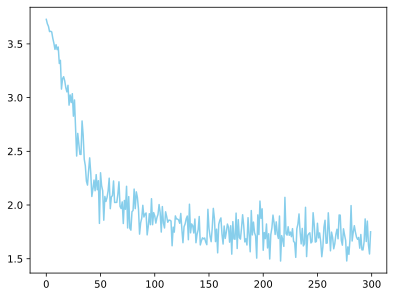

In [19]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.style.use("seaborn")

plt.plot(range(len(loss_values)), loss_values, color="skyblue")
plt.show()

### Conclusion

To get an embedding for a word, we will need to get the neurons value in the hidden layer. It can be done using the below code.

In [20]:
def get_word_embedding(model, word):
    embeddings = model.linear2.weight.detach().cpu()
    id = word_id[word]
    return embeddings[id]

get_word_embedding(model, "machine")

tensor([ 0.3328,  0.2982, -0.8266, -0.4253,  0.8422,  0.2680,  0.3761, -1.3822,
         0.0498,  1.2050])